root
 |-- Date: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- PTID: long (nullable = true)
 |-- LBMP: double (nullable = true)
 |-- Marginal_cost_losses: double (nullable = true)
 |-- Marginal_cost_congestion: double (nullable = true)
 |-- hour: long (nullable = true)
 |-- day_of_week: long (nullable = true)
 |-- holiday: boolean (nullable = true)
 |-- avg_price_past_day: double (nullable = true)
 |-- price_past_day: double (nullable = true)
 |-- price_past_week: double (nullable = true)

index	pearson
6	0.217282
7	-0.121769
8	-0.0144057
9	0.810446
10	0.848452
11	0.61357
MSE = inf


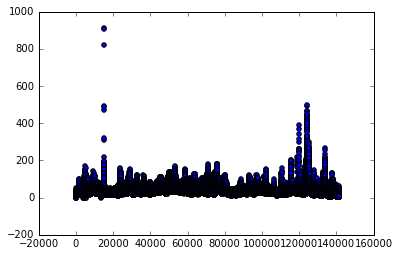

In [1]:
%matplotlib inline
import settings
import matplotlib.pylab as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.stat import Statistics

def get_settings():
    db_name = settings.DATABASE_NAME
    table = settings.TABLE
    db_user = settings.DATABASE_USER
    db_pass = settings.DATABASE_PASS
    zone_name_to_forecast = settings.ZONE_NAME_TO_FORECAST
    return db_name, table, db_user, db_pass, zone_name_to_forecast    
    
def explore_data(db_name, table, db_user, db_pass, zone_name_to_forecast):
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    mysql_url = "jdbc:mysql://localhost:3306/"+db_name
    df = sqlContext.read.format('jdbc').options(url=mysql_url, driver = "com.mysql.jdbc.Driver", dbtable=table, user=db_user, password=db_pass).load()
    df_zone = df[df['Name'] == zone_name_to_forecast]
    pandas_df = df_zone.toPandas()
    pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
    pandas_df['hour'] = pd.DatetimeIndex(pandas_df['Date']).hour
    pandas_df['day_of_week'] = pandas_df['Date'].dt.dayofweek
    cal = calendar()
    holidays = cal.holidays(start=pandas_df['Date'].iloc[0], end=pandas_df['Date'].iloc[-1])
    pandas_df['holiday'] = pandas_df['Date'].isin(holidays)
    pandas_df['avg_price_past_day'] = pd.rolling_mean(pandas_df['LBMP'], window=24).shift(1)
    pandas_df['price_past_day'] = pandas_df['LBMP'].shift(24)
    pandas_df['price_past_week'] = pandas_df['LBMP'].shift(168)
    plt.scatter(pandas_df.index, pandas_df['LBMP'])
    pandas_df = pandas_df.dropna(axis=0)
    spark_df = sqlContext.createDataFrame(pandas_df)
    spark_df.printSchema()
    data = spark_df.map(lambda p: LabeledPoint(p[3], p[6:]))
    numFeatures = data.take(1)[0].features.size
    labelRDD = data.map(lambda p: p.label)
    corrType = 'pearson'
    print '%s\t%s' % ('index', 'pearson') 
    for i in range(numFeatures):
        featureRDD = data.map(lambda p: p.features[i])
        corr = Statistics.corr(labelRDD, featureRDD, corrType)
        print '%d\t%g' % (6+i, corr) 
    sc.stop()
    return pandas_df

def predict(pandas_df):
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    train_df = pandas_df[:-168]
    test_df = pandas_df[-168:]
    train = sqlContext.createDataFrame(train_df)
    test = sqlContext.createDataFrame(test_df)
    train_data = train.map(lambda p: LabeledPoint(p[3], p[9:]))
    test_data = test.map(lambda p: LabeledPoint(p[3], p[9:]))
    model = LinearRegressionWithSGD.train(train_data)
    tp = test_data.map(lambda p: (float(model.predict(p.features)), p.label))
    #print tp.collect()
    #test_mse = tp.map(lambda (t, p): (t - p)**2).reduce(lambda x, y: x + y) / tp.count()
    #print 'test mse', test_mse 
    metrics = RegressionMetrics(tp)
    print "MSE = %s" % metrics.meanSquaredError
    sc.stop()
    
def main():
    db_name, table, db_user, db_pass, zone_name_to_forecast = get_settings()
    pandas_df = explore_data(db_name, table, db_user, db_pass, zone_name_to_forecast)
    predict(pandas_df)

if __name__ == '__main__':
    main()